In [1]:
pip install geopandas rasterio scikit-learn matplotlib numpy pandas shapely

  Obtaining dependency information for rasterio from https://files.pythonhosted.org/packages/7e/1f/56462740694de764fde264051224fcbf800dad43cac92a66753153128866/rasterio-1.4.3-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for affine from https://files.pythonhosted.org/packages/0b/f7/85273299ab57117850cc0a936c64151171fac4da49bc6fba0dad984a7c5f/affine-2.4.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/25.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.5 MB 393.8 kB/s eta 0:01:05
   ---------------------------------------- 0.1/25.5 MB 901.1 kB/s eta 0:00:29
   ---------------------------------------- 0.2/25.5 MB 1.2 MB/s eta 0:00:22
   ---------------------------------------- 0.3/25.5 MB 1.3 MB/s eta 0:00:20
    --------------------------------------- 0.4/25.5 MB 1.3 MB/s eta 0:00:19
    --------------------------------------- 0.5/25.5 MB 1.5 MB/s

1 65535


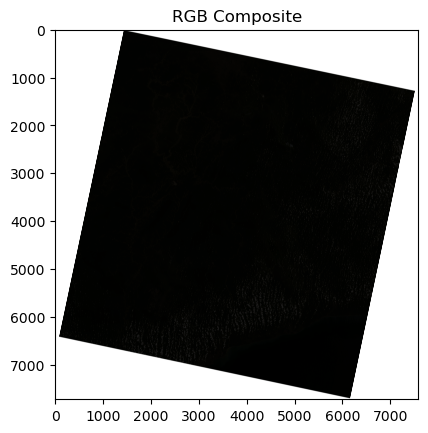

In [16]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

#Load satellite images (bands) 
bands = [r'C:/Users/FrancisAsanteNsiah/Desktop/STUFF\boj/My_Project/LCC-using-satellite-image-ML/satelliteImages/RT_LC09_L2SP_194056_20240417_20240418_02_T1_SR_B4.TIF',
         r'C:/Users/FrancisAsanteNsiah/Desktop/STUFF\boj/My_Project/LCC-using-satellite-image-ML/satelliteImages/RT_LC09_L2SP_194056_20240417_20240418_02_T1_SR_B3.TIF',
         r'C:/Users/FrancisAsanteNsiah/Desktop/STUFF\boj/My_Project/LCC-using-satellite-image-ML/satelliteImages/RT_LC09_L2SP_194056_20240417_20240418_02_T1_SR_B2.TIF'
        ]

images = [rasterio.open(band) for band in bands]

print(red.min(), red.max())

# Plot RGB composite
red = images[0].read(1)
green = images[1].read(1)
blue = images[2].read(1)

rgb = np.dstack((red, green, blue)) / 65535.0
rgb = np.clip(rgb, 0, 1)

plt.imshow(rgb)
plt.title("RGB Composite")
plt.show()